* [train.csv / test.csv] : https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/data

#Part4. [실습7] 자동차 제조 테스트 공정 시간 예측하기

* matplotlib 한글 깨짐 현상 해결
> 셀 실행 후 런타임 재시작 필요

In [1]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm
from matplotlib import pyplot as plt

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

plt.rc('font', family=font_name)

fm._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 160815 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
from matplotlib import pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

## 01. 데이터 소개 및 분석프로세스 수립
 : "강의자료 → Ch09. [실습7] 자동차 제조 테스트 공정 시간 예측하기" 참고

## 02. 데이터 준비를 위한 EDA 및 전처리

### 0. 데이터 불러오기

In [ ]:
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from itertools import combinations

import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
from sklearn.base import BaseEstimator,TransformerMixin,ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import FeatureAgglomeration

from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.linear_model import ElasticNetCV, LassoLarsCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.utils import check_array
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectFromModel

seed = 40

import warnings
warnings.filterwarnings('ignore')
color = sns.color_palette()
%matplotlib inline

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/강의/실습자료/data/ch9/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/강의/실습자료/data/ch9/test.csv")
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (4209, 378)
Test shape :  (4209, 377)


In [ ]:
train_df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


> Feature 데이터
1. **ID**
2. **y** : Target Feature
3. **X0-X385**

### Target Feature

> Scatter Plot

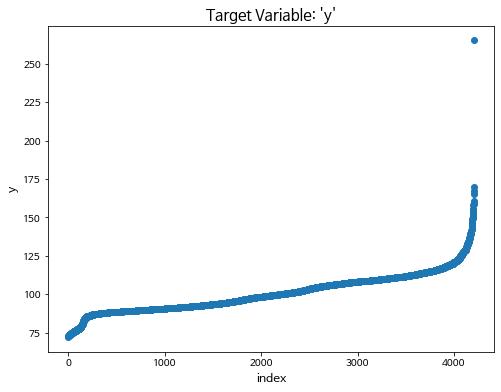

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.y.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Target Variable: 'y'",fontsize=15)
plt.show()

> Histogram

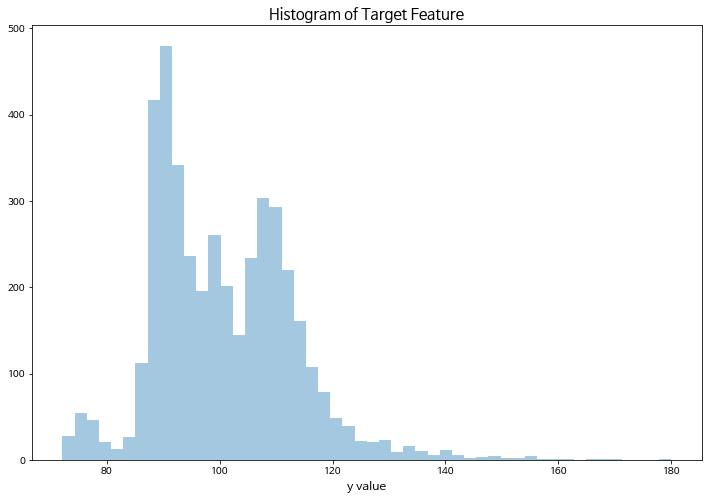

In [ ]:
ulimit = 180
train_df['y'].loc[train_df['y']>ulimit] = ulimit

plt.figure(figsize=(12,8))
sns.distplot(train_df.y.values, bins=50, kde=False)
plt.xlabel('y value', fontsize=12)
plt.title("Histogram of Target Feature",fontsize=15)
plt.show()

In [ ]:
print('최소값: {} 최대값: {} 평균값: {} 표준편차: {}'.format(min(train_df['y'].values), max(train_df['y'].values), train_df['y'].values.mean(), train_df['y'].values.std()))
print('180보다 큰 숫자들 개수: {}'.format(np.sum(train_df['y'].values > 180)))

최소값: 72.11 최대값: 180.0 평균값: 100.64904727963888 표준편차: 12.481281731120474
180보다 큰 숫자들 개수: 0


### 데이터 탐색

In [ ]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,369
1,float64,1
2,object,8


In [ ]:
dtype_df.loc[:10,:]

,Count,Column Type
0,ID,int64
1,y,float64
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


#### 결측값

In [ ]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


In [ ]:
cols = [c for c in train_df.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))
print('Feature types:')
train_df[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

In [ ]:
counts = [[], [], []]
for c in cols:
    typ = train_df[c].dtype
    uniq = len(np.unique(train_df[c]))
    if uniq == 1: counts[0].append(c)
    elif uniq == 2 and typ == np.int64: counts[1].append(c)
    else: counts[2].append(c)

print('Feature 값이 1개인 경우 : {} Feature 값이 2개인 경우: {} 범주형 Feature 인 경우: {}\n'.format(*[len(c) for c in counts]))

print('Feature 값이 1개인 경우: ', counts[0])
print('Feature 값이 2개인 경우: ', counts[2])

Feature 값이 1개인 경우 : 12 Feature 값이 2개인 경우: 356 범주형 Feature 인 경우: 8

Feature 값이 1개인 경우:  ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
Feature 값이 2개인 경우:  ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


In [ ]:
unique_values_dict = {}
for col in train_df.columns:
    if col not in ["ID", "y", "X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        unique_value = str(np.sort(train_df[col].unique()).tolist())
        tlist = unique_values_dict.get(unique_value, [])
        tlist.append(col)
        unique_values_dict[unique_value] = tlist[:]
for unique_val, columns in unique_values_dict.items():
    print("컬럼에 존재하는 유일한 값들 : ",unique_val)
    print(columns)
    print("--------------------------------------------------")

컬럼에 존재하는 유일한 값들 :  [0, 1]
['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145', 'X146', 'X147', 'X1

#### 범주형 Features

In [ ]:
cat_feat = counts[2]
train_df[cat_feat].head()

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n


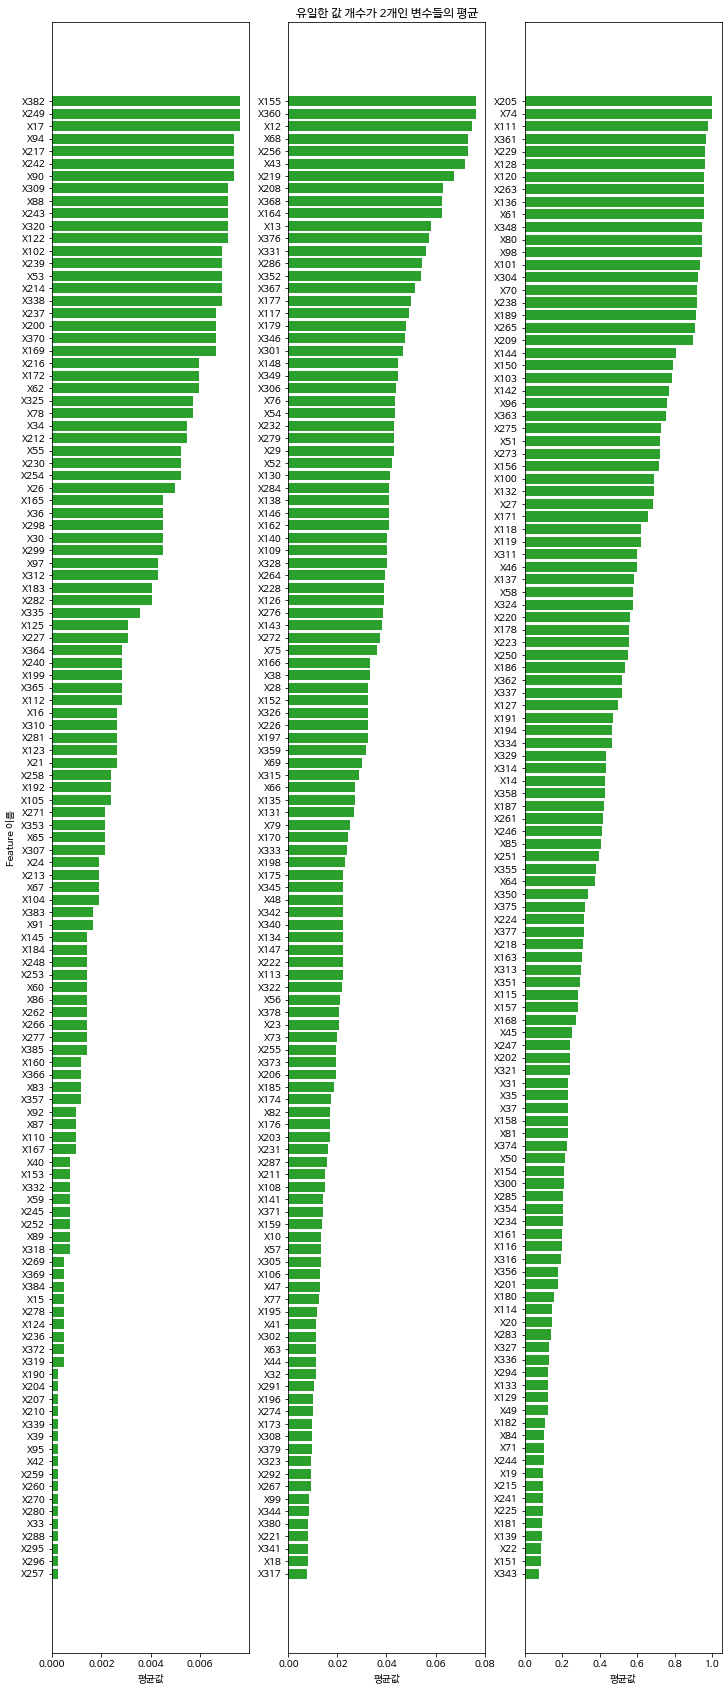

In [ ]:
binary_means = [np.mean(train_df[c]) for c in counts[1]]
binary_names = np.array(counts[1])[np.argsort(binary_means)]
binary_means = np.sort(binary_means)

fig, ax = plt.subplots(1, 3, figsize=(12,30))
ax[0].set_ylabel('Feature 이름')
ax[1].set_title('유일한 값 개수가 2개인 변수들의 평균')
for i in range(3):
    names, means = binary_names[i*119:(i+1)*119], binary_means[i*119:(i+1)*119]
    ax[i].barh(range(len(means)), means, color=color[2])
    ax[i].set_xlabel('평균값')
    ax[i].set_yticks(range(len(means)))
    ax[i].set_yticklabels(names, rotation='horizontal')
plt.show()

## 03. 머신러닝 모델링

### Baseline Model 1: xgboost model 

#### Label Encoding

In [ ]:
for f in ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values)) # Fit label encoder
        train_df[f] = lbl.transform(list(train_df[f].values)) # Transform labels to normalized encoding.

#### 데이터 준비

In [ ]:
train_y = train_df['y'].values
train_X = train_df.drop(["ID", "y"], axis=1)

#### 모델 생성

In [ ]:
def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100, feval=xgb_r2_score, maximize=True)

[11:46:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#### Feature Importances

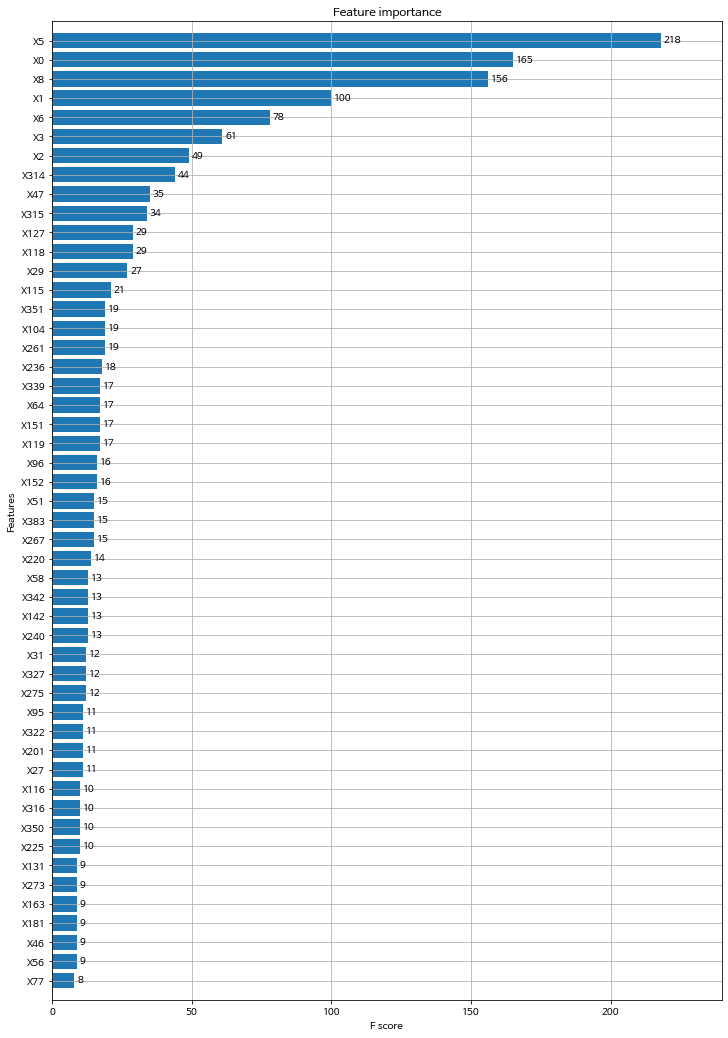

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Baseline Model 2: Random Forest model 

#### 모델 생성

In [ ]:
from sklearn import ensemble
model = ensemble.RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=0.2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

#### Feature Importances

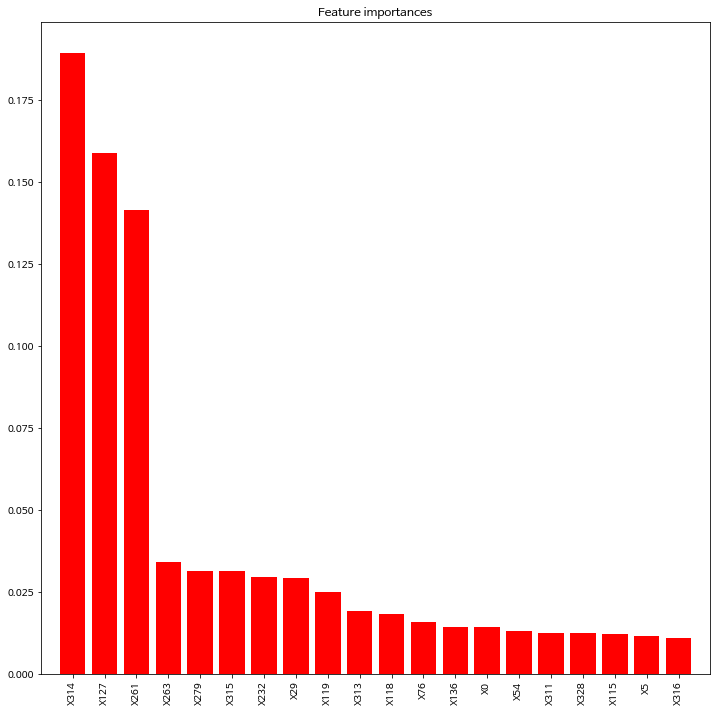

In [ ]:
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

## 4. 다양한 차원 축소 기법을 활용한 Feature Selection

### 일반적인 적용


#### 차원 축소 기법의 종류

* Principal Component Analysis [PCA]
* Independent Component Analysis [ICA]
* Truncated SVD [TSVD]
* Gaussian Random Projection [GRP]
* Sparse Random Projection [SRP]
* Non-negative Matrix factorization [NMF]
* Feature Agglomeration [FAG]

#### 데이터 준비

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/강의/실습자료/data/ch9/train.csv")
test = pd.read_csv("/content/drive/MyDrive/강의/실습자료/data/ch9/test.csv")

y_train = train['y']
train = train.drop('y', axis=1)

#### Label Encoding

In [ ]:
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

#### 차원 축소 방법 적용

In [ ]:
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train)
tsvd_results_test = tsvd.transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train)
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train)
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train)
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(train)
srp_results_test = srp.transform(test)

# NMF
nmf = NMF(n_components=n_comp, init='nndsvdar', random_state=420)
nmf_results_train = nmf.fit_transform(train)
nmf_results_test = nmf.transform(test)

# FAG
fag = FeatureAgglomeration(n_clusters=n_comp, linkage='ward')
fag_results_train = fag.fit_transform(train)
fag_results_test = fag.transform(test)

In [ ]:
dim_reds = list()
train_pca = pd.DataFrame()
test_pca = pd.DataFrame()

train_ica = pd.DataFrame()
test_ica = pd.DataFrame()

train_tsvd = pd.DataFrame()
test_tsvd = pd.DataFrame()

train_grp = pd.DataFrame()
test_grp = pd.DataFrame()

train_srp = pd.DataFrame()
test_srp = pd.DataFrame()

train_nmf = pd.DataFrame()
test_nmf = pd.DataFrame()

train_fag = pd.DataFrame()
test_fag = pd.DataFrame()


for i in range(1, n_comp + 1):
    train_pca['pca_' + str(i)] = pca2_results_train[:, i - 1]
    test_pca['pca_' + str(i)] = pca2_results_test[:, i - 1]

    train_ica['ica_' + str(i)] = ica2_results_train[:, i - 1]
    test_ica['ica_' + str(i)] = ica2_results_test[:, i - 1]

    train_tsvd['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    test_tsvd['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

    train_grp['grp_' + str(i)] = grp_results_train[:, i - 1]
    test_grp['grp_' + str(i)] = grp_results_test[:, i - 1]

    train_srp['srp_' + str(i)] = srp_results_train[:, i - 1]
    test_srp['srp_' + str(i)] = srp_results_test[:, i - 1]
    
    train_nmf['nmf_' + str(i)] = nmf_results_train[:, i - 1]
    test_nmf['nmf_' + str(i)] = nmf_results_test[:, i - 1]
    
    train_fag['fag_' + str(i)] = fag_results_train[:, i - 1]
    test_fag['fag_' + str(i)] = fag_results_test[:, i - 1]
    
dim_reds.append(('pca', train_pca, test_pca))
dim_reds.append(('ica', train_ica, test_ica))
dim_reds.append(('tsvd', train_tsvd, test_tsvd))
dim_reds.append(('grp', train_grp, test_grp))
dim_reds.append(('srp', train_srp, test_srp))
dim_reds.append(('nmf', train_nmf, test_nmf))
dim_reds.append(('fag', train_fag, test_fag))

#### 복수의 차원 축소 기법 적용에 따른 성능 실험

In [ ]:
combs = [combinations(dim_reds, i+1) for i in range(0, len(dim_reds))]

In [ ]:
dr_scores = list()
for c1 in combs:
    for c2 in c1:   
        train_, test_, id_ = list(), list(), list()
        for k in c2:
            train_.append(k[1])
            test_.append(k[2])
            id_.append(k[0])
               
        train_x = train.reset_index(drop=True)
        train_.append(train_x)
        test_.append(test)
            
        train_ = pd.concat(train_, axis=1)
        test_ = pd.concat(test_, axis=1)
        
        
# ============================ DecisionTree Model =======================  
#         model = DecisionTreeRegressor(max_depth=3, min_samples_split=11, presort=False, random_state=1729)
#         model.fit(train_, y_train)
#         c_score = r2_score(y_train, model.predict(train_))

# ============================ ElasticNet model =======================
        model = ElasticNet(alpha=0.014, tol=0.11, l1_ratio=0.99999999, 
                           normalize=True, fit_intercept=False, warm_start=True, 
                          copy_X=True, precompute=False, positive=False, max_iter=60)
        model.fit(train_, y_train)
        c_score = r2_score(y_train, model.predict(train_))
        
# ============================ Ridge model =============================
#         model = Ridge()
#         model.fit(train_, y_train)
#         c_score = r2_score(y_train, model.predict(train_))
        
# ================================ lightgbm model =======================
#         lgb_params = {
#         'num_iterations': 200,
#         'learning_rate': 0.045,
#         'max_depth': 3,
#         'bagging_fraction': 0.93,
#         'metric': 'l2_root',
#         }

#         dtrain = lgb.Dataset(train_, y_train)
#         num_round = 1200
#         model = lgb.train(lgb_params, dtrain, num_round)
#         c_score = r2_score(y_train, model.predict(train_))

# ================================= xgboost model ============================
#         xgb_params = {
#         'n_trees': 520, 
#         'eta': 0.0045,
#         'max_depth': 4,
#         'subsample': 0.93,
#         'objective': 'reg:linear',
#         'eval_metric': 'rmse',
#         'base_score': np.mean(y_train),
#         }

#         dtrain = xgb.DMatrix(train_, y_train)

#         num_boost_rounds = 1250
#         model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_rounds)
#         c_score = r2_score(y_train, model.predict(dtrain))
        
        dr_scores.append((','.join(id_), c_score))

In [ ]:
# baseline scoring for comparision
model = ElasticNet(alpha=0.014, tol=0.11, l1_ratio=0.99999999, 
                           normalize=True, fit_intercept=False, warm_start=True, 
                          copy_X=True, precompute=False, positive=False, max_iter=60)
model.fit(train, y_train)
full_score = r2_score(y_train, model.predict(train))

dr_scores.append(('baseline', full_score))

Plotting the graph


> Please open the plots in a separate tab for better labels and clarity.



In [ ]:
for dr_score in dr_scores:
  if dr_score[1] < 0:
    dr_score = (dr_score[0], 0)

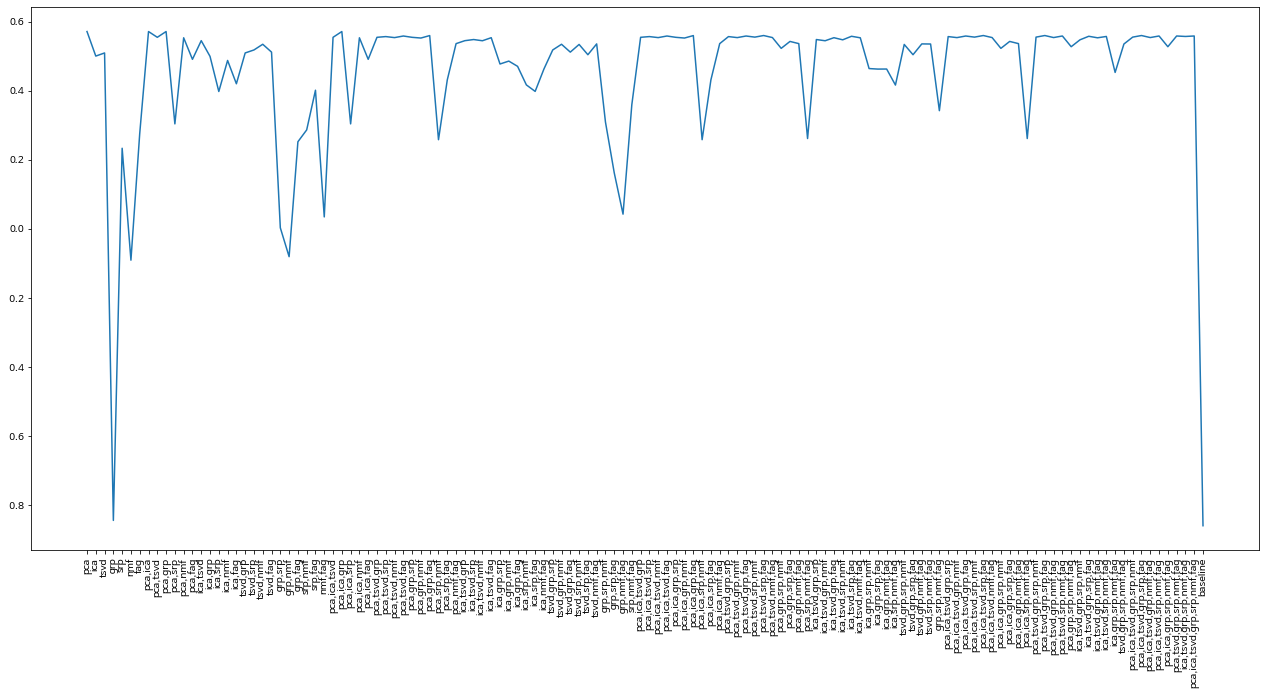

In [ ]:
x_axis = [c[0] for c in dr_scores]
y_axis = [c[1] for c in dr_scores]
fig, ax = plt.subplots(figsize=(22, 10))
plt.plot(y_axis)
ax.set_xticks(range(len(x_axis)))
ax.set_xticklabels(x_axis, rotation='vertical')
plt.show()

#### 모델 성능 비교

In [ ]:
sorted_id = np.argsort(y_axis)
print("점수 하위 7개 차원 축소 기법 조합 : {}".format(np.array(x_axis)[sorted_id[:7]]))
print("점수 상위 7개 차원 축소 기법 조합 : {}".format(np.array(x_axis)[sorted_id[-7:]]))

print("\n\n가장 높은 점수를 가지는 조합 : {}".format(np.array(x_axis)[sorted_id[-1]]))

Combinations which has the lowest score: ['baseline' 'grp' 'nmf' 'grp,nmf' 'grp,srp' 'nmf,fag' 'grp,nmf,fag']
Combinations which has the highest score: ['pca,ica,tsvd,srp,fag' 'pca,tsvd,grp,srp,fag' 'pca,ica,tsvd,grp,srp,fag'
 'pca,grp' 'pca,ica,grp' 'pca,ica' 'pca']


Best Score: pca


In [ ]:
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
# Dimensionality reduction techniques
n_comp = 12

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train)
grp_results_test = grp.transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train)
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train)
ica2_results_test = ica.transform(test)

for i in range(1, n_comp+1):
    train['grp_' + str(i)] = grp_results_train[:,i-1]
    test['grp_' + str(i)] = grp_results_test[:, i-1]
    
    train['pca_' + str(i)] = pca2_results_train[:,i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]
    
    train['ica_' + str(i)] = ica2_results_train[:,i-1]
    test['ica_' + str(i)] = ica2_results_test[:, i-1]
    
y_mean = np.mean(y_train)

In [ ]:
import xgboost as xgb

# Prepare dict of params for xgboost model.
xgb_params = {
    'n_trees': 500, 
    'eta': 0.005,
    'max_depth':6,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1}


# Creating DMatrices for Xgboost training
dtrain = xgb.DMatrix(train, y_train)
dtest = xgb.DMatrix(test)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params,dtrain,num_boost_round=700,verbose_eval=50,show_stdv=False)

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# Train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

[0]	train-rmse:12.6392	test-rmse:12.6388
[50]	train-rmse:11.0209	test-rmse:11.1729
[100]	train-rmse:9.8524	test-rmse:10.1789
[150]	train-rmse:9.01292	test-rmse:9.52686
[200]	train-rmse:8.4128	test-rmse:9.11133
[250]	train-rmse:7.97614	test-rmse:8.852
[300]	train-rmse:7.65732	test-rmse:8.69525
[350]	train-rmse:7.40765	test-rmse:8.6073
[400]	train-rmse:7.19982	test-rmse:8.55762
[450]	train-rmse:7.02644	test-rmse:8.52997
[500]	train-rmse:6.8771	test-rmse:8.51921
[550]	train-rmse:6.74153	test-rmse:8.51474
[600]	train-rmse:6.62295	test-rmse:8.51744
[650]	train-rmse:6.51535	test-rmse:8.52048
[699]	train-rmse:6.41603	test-rmse:8.52524
700
[12:47:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#### Feature Importances

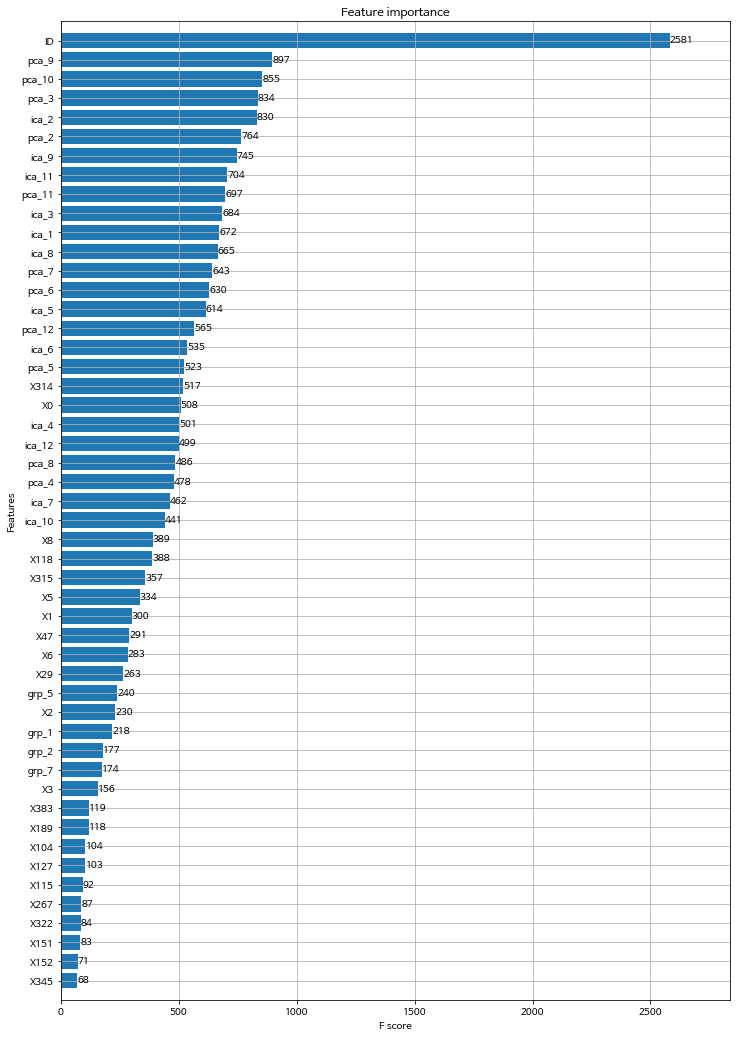

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import r2_score

print(r2_score(dtrain.get_label(), model.predict(dtrain)))

0.7131165239962037


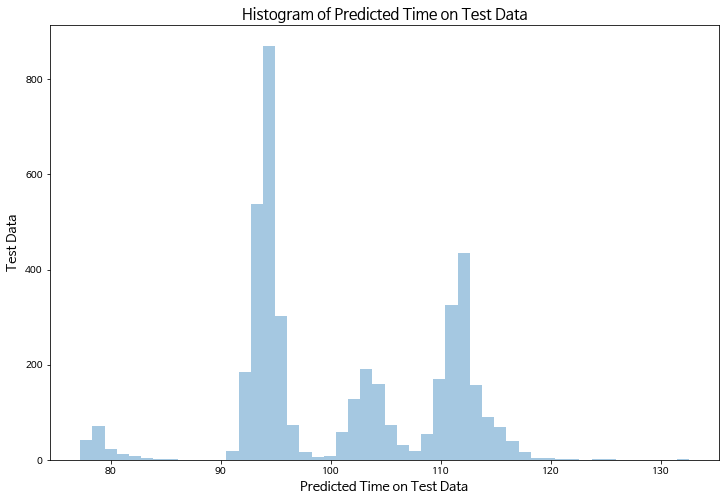

In [ ]:
y_pred = model.predict(dtest)
output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
output.to_csv('XGB_test_results.csv', index=False)
output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
plt.figure(figsize=(12,8))
sns.distplot(output.y.values, bins=50, kde=False)
plt.xlabel('Predicted Time on Test Data', fontsize=13)
plt.ylabel('Test Data', fontsize=13)
plt.title('Histogram of Predicted Time on Test Data', fontsize=15)
plt.show()

### Stacked Regression model 적용

#### 각 Estimator 의 결과를 합칠 클래스 생성
* BaseEstimator : https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html
* TransformerMixin : https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html

> 파이썬 클래스, 상속, 멤버 변수, 생성자 등의 기초 지식 필요

In [ ]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator
    
    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    """
    1. np.hstack : 두 배열을 가로로 이어붙이는 함수
    2. predict_proba 의 출력은 각 클래스에 대한 확률
    3. issubclass(subclass, superclass) -> subclass가 superclass의 자식 클래스인지, 다시 말해 subclass가 superclass를 상속받는지 판단해 True, False 를 반환
    4. hasattr(self.estimator, 'predict_proba') -> self.estimator(우리의 머신러닝 모델) 에 'predict_proba' 라는 멤버가 있는지 판단해 True, False 를 반환
    """
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):

            # X 에 각 클래스에 대한 확률을 이어 붙여준다.
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # 위의 X_transformed 에 예측 클래스를 이어 붙여준다.
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/강의/실습자료/data/ch9/train.csv")
test = pd.read_csv("/content/drive/MyDrive/강의/실습자료/data/ch9/test.csv")

print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (4209, 378)
Test shape :  (4209, 377)


#### Label Encoding

In [ ]:
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))# Fit label encoder
        train[c] = lbl.transform(list(train[c].values))# Transform labels to normalized encoding.
        test[c] = lbl.transform(list(test[c].values))# Transform labels to normalized encoding.


#### 데이터 준비

In [ ]:
train_y = train['y'].values
y_mean = np.mean(train_y)
id_test = test['ID'].values
train = train.drop(["ID"], axis=1)
test = test.drop(["ID"], axis=1)                  

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

usable_columns = list(set(train.columns) - set(['y']))

In [ ]:
n_comp = 15

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train.drop(["y"], axis=1))
tsvd_results_test = tsvd.transform(test)
# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=42)
grp_results_train = grp.fit_transform(train.drop(["y"], axis=1))
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=42)
srp_results_train = srp.fit_transform(train.drop(["y"], axis=1))
srp_results_test = srp.transform(test)

for i in range(1, n_comp+1):
    
    train['tsvd_' + str(i)] = tsvd_results_train[:,i-1]
    test['tsvd_' + str(i)] = tsvd_results_test[:, i-1]
    
    train['pca_' + str(i)] = pca2_results_train[:,i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]
    
    train['ica_' + str(i)] = ica2_results_train[:,i-1]
    test['ica_' + str(i)] = ica2_results_test[:, i-1]
    
    train['grp_' + str(i)] = grp_results_train[:, i-1]
    test['grp_' + str(i)] = grp_results_test[:, i-1]

    train['srp_' + str(i)] = srp_results_train[:, i-1]
    test['srp_' + str(i)] = srp_results_test[:,i-1]

In [ ]:
final_train = train[usable_columns].values
final_test = test[usable_columns].values

import xgboost as xgb

xgb_params = {
    'n_trees': 500, 
    'eta': 0.005,
    'max_depth':5,
    'subsample': 0.9,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean,
    'silent': 1}

In [ ]:
# DMatrix : Numpy 입력 파라미터를 받아서 만들어지는 XGBoost 전용 데이터 --> Input : Feature 데이터, Label 데이터
dtrain = xgb.DMatrix(train.drop(["y"], axis=1), train_y)
dtest = xgb.DMatrix(test)

In [ ]:
# xgboost & cross-validation
cv_result = xgb.cv(xgb_params,dtrain,num_boost_round=1000,verbose_eval=50,show_stdv=False)

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

[0]	train-rmse:12.6395	test-rmse:12.6385
[50]	train-rmse:11.0506	test-rmse:11.1538
[100]	train-rmse:9.91342	test-rmse:10.1558
[150]	train-rmse:9.11255	test-rmse:9.50348
[200]	train-rmse:8.55327	test-rmse:9.08783
[250]	train-rmse:8.15821	test-rmse:8.82933
[300]	train-rmse:7.8696	test-rmse:8.6755
[350]	train-rmse:7.65352	test-rmse:8.58383
[400]	train-rmse:7.48338	test-rmse:8.53482
[450]	train-rmse:7.32723	test-rmse:8.51293
[500]	train-rmse:7.18602	test-rmse:8.50275
[550]	train-rmse:7.06635	test-rmse:8.49974
[600]	train-rmse:6.96052	test-rmse:8.4999
[650]	train-rmse:6.86005	test-rmse:8.50591
[700]	train-rmse:6.75653	test-rmse:8.51387
[750]	train-rmse:6.66758	test-rmse:8.52196
[800]	train-rmse:6.58247	test-rmse:8.52987
[850]	train-rmse:6.49963	test-rmse:8.5383
[900]	train-rmse:6.42239	test-rmse:8.54542
[950]	train-rmse:6.3521	test-rmse:8.5533
[999]	train-rmse:6.28114	test-rmse:8.5608
1000


In [ ]:
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
y_pred = model.predict(dtest)

[14:34:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
from sklearn.pipeline import make_pipeline, make_union
Stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001,loss="huber",max_features=0.55, 
                                                          min_samples_leaf=18, 
                                                          min_samples_split=14, subsample=0.7)),
    LassoLarsCV())


Stacked_pipeline.fit(final_train, train_y)
predictions = Stacked_pipeline.predict(final_test)

In [ ]:
print('R2 score on train data:')
print(r2_score(train_y,Stacked_pipeline.predict(final_train)*0.2855 + model.predict(dtrain)*0.7145))

sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = y_pred*0.75 + predictions*0.25
sub.to_csv('stacked_model_pred.csv', index=False)

R2 score on train data:
0.6812695507846622


#### Feature Importances

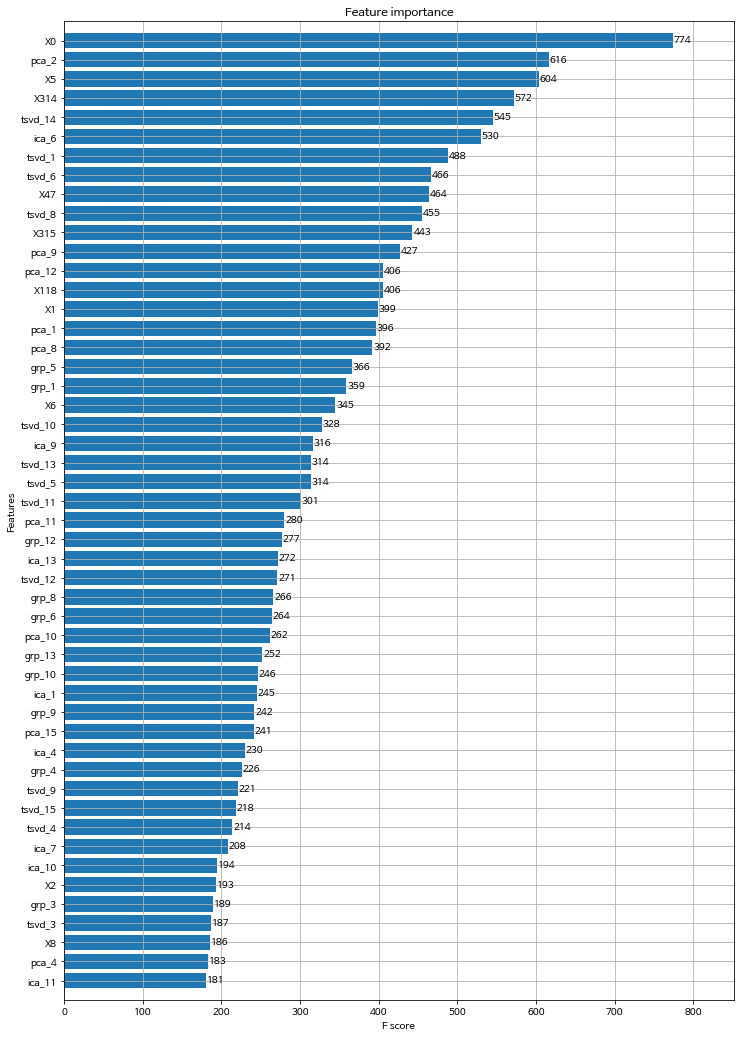

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()